In [1]:
import pandas as pd
import numpy as np
import random
from scipy.special import softmax
from datetime import datetime, timedelta
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family = 'NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

In [2]:
path = '/mnt/d/data/getamped/' 
df = pd.read_csv(path + 'getamped_300.csv', index_col = 0)
df_score = pd.read_csv(path + '겟앰상점악평점.csv', encoding = 'cp949').iloc[:,1:]

## 
## 본 로그는 유저의 성향, 계급, 시간대 기반 플레이 분포를 반영,
# 가설에 대한 검증 분석 연습을 위해 현실적인 조건을 반영하여 시뮬레이션했습니다.


In [3]:
# 계급별 labeling
class_level = {
    '금황룡' : 0, '은황룡' : 1, '동황룡' : 2, '금청룡' : 3, '은청룡' : 4, '동청룡' : 5, '금백호' : 6, '은백호' : 7, '동백호' : 8, '금주작' : 9, '은주작' : 10,
       '동주작' : 11, '금현무' : 12, '은현무' : 13, '동현무' : 14, '금코발' : 15, '은코발' : 16, '동코발' : 17, '금곰발' : 18, '은곰발' : 19,
       '동곰발' : 20
}


df['계급_label'] = df['계급'].map(class_level)

df.head(2)

,계급,액세서리,계급_label
0,동황룡,"철장갑,파이어크로스,미스터리테트라,우리엘머누버,산타구두",2
1,금청룡,"호루스의가면,키메라건틀릿,미스터리테트라,미스터리오브,미스터리큐브",3


In [4]:
# 맵 랜덤 초이스

top_maps = ['원형 경기장', '지하 감옥']
pop_maps = ['시티', '격투 경기장', '비밀의 방', '타이타닉']
mid_maps = ['망자의 미궁', '메카신 대사원', '천년정글', '골렘의 전당']
others = [
    'GWF', 'GWF 2008', '눈싸움 장', '고산대불', '고성', '고성2', '공성', '고대의 신전',
    '길거리', '남극', '노벨 항공모함', '노천탕', '네오 서울', '네오 사찰', '달나라', '대성당', '데스터널',
    '등대', '러시모어', '마녀들의 밤', '무릉도원', '문릿 와일드니스', '불의 제단', '브로큰 타워',
    '삐에로의 무대', '사각의 링', '사각 경기장', '사이트-51', '사신수 신전', '산타의 집', '수정 동굴',
    '스위트 협곡', '스카이쉽', '스타 콜로세움', '시티2', '아바타 신전', '아이스', '오다이바', '오션파크',
    '와이키키', '온천', '올림프드 2008', '용암동굴', '우미관', '우주 경기장', '우주 정거장', '우주항구',
    '앰프드 공터', '앰프드 교실', '앰프드 기념관', '앰프드 체육관', '앰프드 훈련소', '에라드래곤 공장',
    '위즈덤 라이브러리', '재즈바', '죽음의 늪', '지하철', '지하 투기장', '차이나 타운', '책상',
    '천공의 투기장', '천국과 지옥', '코만도', '콜로세움', '큐브 독', '킬에라', '킹 캐슬', '타운', '탈옥',
    '파티장', '푸른 해수욕장', '풍력 발전소', '폐기물 처리장', '해저', '화산동굴', '황야', '황혼 우주센터',
    '동굴', '물의 신전', '월하죽림', '천공의 제단', '하늘 정원', '하수구', '헬기장', '교량', '바벨타워'
]

# top, mid, pop, others
weights_by_rank = {
        '기타': [0.09, 0.01, 0.5, 0.4],
        '현무': [0.35, 0.05, 0.5, 0.2],
        '주작': [0.45, 0.05, 0.4, 0.1],
        '백호': [0.65, 0.1, 0.22, 0.03],
        '용': [0.6, 0.3, 0.07, 0.03]
    }

# 계급별 랭크에 따라 가중치를 곱해 4 분류중 선택
# 4 분류 내에서는 랜덤 초이스하여 유저별 맵 선택 로직완성

def get_rank_class(class_name):
    level = class_level.get(class_name, 20)  # 예외시 가장 낮은 계급 처리
    if level <= 2: return '용'
    elif level <= 5: return '용'
    elif level <= 8: return '백호'
    elif level <= 11: return '주작'
    elif level <= 14: return '현무'
    else: return '기타'

def select_map_by_user_class(user_class):
    rank = get_rank_class(user_class)
    weights = weights_by_rank[rank]
    
    category = random.choices(
        population=['top', 'mid', 'pop', 'other'],
        weights=weights,
        k=1
    )[0]
    
    if category == 'top':
        return random.choice(top_maps)
    elif category == 'mid':
        return random.choice(mid_maps)
    elif category == 'pop':
        return random.choice(pop_maps)
    else:
        return random.choice(others)
    


In [5]:
# 계급생성

rank_groups = {
    '황룡': ['금황룡', '은황룡', '동황룡'],
    '청룡': ['금청룡', '은청룡', '동청룡'],
    '백호': ['금백호', '은백호', '동백호'],
    '주작': ['금주작', '은주작', '동주작'],
    '현무': ['금현무', '은현무', '동현무'],
    '코끼리': ['금코발', '은코발', '동코발'],
    '곰': ['금곰발', '은곰발', '동곰발']
}

# 전체 비율
group_weights = {
    '황룡': 0.01,
    '청룡': 0.07,
    '백호': 0.27,
    '주작': 0.20,
    '현무': 0.21,
    '코끼리': 0.13,
    '곰': 0.11
}

# 세부 계급 및 개별 가중치 생성
class_names = []
class_weights = []

for group, classes in rank_groups.items():
    base_weight = group_weights[group] / 3
    for cls in classes:
        class_names.append(cls)
        class_weights.append(base_weight)

def generate_random_user_class():
    return random.choices(
        population=class_names,
        weights=class_weights,
        k=1
    )[0]


# for _ in range(100):
#     print(generate_random_user_class())

In [6]:
# 승패 생성
def determine_win(user_class, acc_perf_score):
    # 계급 레벨 → 실력 스케일링 (0.1~0.7)
    level = class_level.get(user_class, max(class_level.values()))
    level_score = np.interp(level, [min(class_level.values()), max(class_level.values())], [0.7, 0.1])

    # 액세서리 성능 정규화
    acc_score = acc_perf_score / 10

    # 노이즈
    noise = np.random.normal(0, 0.05)

    # 가중합 계산
    final_score = 0.6 * level_score + 0.3 * acc_score + 0.1 * noise

    # 확률 제한
    final_score = np.clip(final_score, 0.05, 0.95)

    return '승' if np.random.rand() < final_score else '패'

In [7]:
# 실 수집 300명 데이터에 따른 계급군 별 외형, 성능, 재미 평균치로 가중치 사전 
class_group_weights = {
    '곰' : (9.163500, 9.174000, 9.248344),
    '백호' : (9.198519, 9.173049, 9.243605),
    '용' : (9.231600, 9.150600, 9.202400),
    '주작' : (9.155633,9.142100, 9.212300),
    '코끼리' : (9.171026, 9.072564, 9.160692),
    '현무' : (9.228968, 9.198254, 9.285063)
}

# class 별 그룹핑 함수 

def get_class_group(class_name):
    if '황룡' in class_name or '청룡' in class_name:
        return '용'
    elif '백호' in class_name:
        return '백호'
    elif '주작' in class_name:
        return '주작'
    elif '현무' in class_name:
        return '현무'
    elif '코발' in class_name:
        return '코끼리'
    elif '곰발' in class_name:
        return '곰'
    else:
        return '기타'

In [8]:
count = {}
l = []
for i in range(len(df)):
    l += df['액세서리'][i].split(',')

for x in l:
    try:
        count[x] += 1
    except:
        count[x] = 1

sort_count = sorted(count.items(), key = lambda x:x[1], reverse = True)

In [9]:
df_score

,액세서리,외형,성능,재미
0,공수도플레임,8.8,9.2,9.5
1,황혼의달,9.3,8.5,8.5
2,프로즌글러브,8.8,8.9,8.8
3,봉인의지팡이(퍼플),5.8,7.8,6.2
4,아쿠아기어,9.5,9.7,9.7
...,...,...,...,...
656,SPY세트,8.2,8.5,8.8
657,스타브로우스렛,8.0,8.6,9.9
658,밥인형,9.2,8.8,9.3
659,폭탄모자,8.0,8.6,9.4


In [10]:
df_score['빈도'] = pd.merge(df_score, pd.DataFrame(sort_count, columns = ['액세서리', '빈도']), how = 'left', on = "액세서리").fillna(0)['빈도']

In [11]:
freq_scaled = np.log1p(df_score['빈도'])  # 로그 스케일
freq_scaled = freq_scaled / freq_scaled.max() 
freq_scaled

0      0.196562
1      0.000000
2      0.000000
3      0.000000
4      0.551818
         ...   
656    0.000000
657    0.000000
658    0.000000
659    0.000000
660    0.000000
Name: 빈도, Length: 661, dtype: float64

In [12]:
sum(class_group_weights[group])

27.585843999999998

In [13]:
def calculate_accessory_probabilities(user_class, df_score, class_group_weights):
    # 1. 계급군 가져오기
    group = get_class_group(user_class)  # 예: '현무'
    weights = np.array(class_group_weights[group])  # (재미, 성능, 외형)
    w1, w2, w3 = weights/(sum(weights))

    # 2. 성향 가중 점수 계산 및 정규화 (0 ~ 1)
    df_score['weighted_score'] = (
        df_score['재미'] * w1 +
        df_score['성능'] * w2 +
        df_score['외형'] * w3
    )

    ws_scaled = df_score['weighted_score']
    ws_scaled = (ws_scaled - ws_scaled.min()) / (ws_scaled.max() - ws_scaled.min())

    # 3. 빈도 보정: log(freq + 1) 및 정규화 (0 ~ 1)
    freq_scaled = np.log1p(df_score['빈도'])  # 로그 스케일
    freq_scaled = freq_scaled / freq_scaled.max()  # 0~1 정규화

    # 4. noise 추가
    noise = np.random.rand(len(df_score))

    df_score['adjusted_score'] = 0.5 * df_score['weighted_score'] + 0.3 * freq_scaled + 0.2 * noise

    # 5. softmax 확률로 변환
    probs = softmax(df_score['adjusted_score'])
    return probs

In [14]:
# 유저의 플레이 시작 시간을 현실적인 시간대로 설정
def generate_play_minute():
    while True:
        minute = int(np.random.normal(loc=1260, scale=120))  # 평균 21:00, 표준편차 3시간
        if (minute >= 360 and minute < 1440) or (minute >= 0 and minute < 240): # 오전 6시 ~ 다음날 오전 4시 가지
            return minute

# 시간대 반영 + 세트 단위 로그 생성 함수
def generate_logs_for_user(user_id, user_class, date):
    logs = []
    MIN_BREAK = 1
    MAX_BREAK = 20
    total_play_minutes = random.randint(30, 360)
    played_minutes = 0
    session_counter = 0

    # realistic 시작 시각 부여
    play_minute = generate_play_minute()
    current_time = datetime.combine(date.date(), datetime.min.time()) + timedelta(minutes=play_minute)

    while played_minutes + 3 + MIN_BREAK <= total_play_minutes:
        set_start_time = current_time
        base_map = select_map_by_user_class(user_class)
        session_id = f"{user_id}_set{session_counter}"
        session_counter += 1

        # 액세서리 선택 (세트당 고정)

        probs = calculate_accessory_probabilities(user_class, df_score, class_group_weights)
        chosen_idx = np.random.choice(df_score.index, p=probs)
        chosen_acc = df_score.iloc[chosen_idx]

        # 세트 시간 랜덤
        set_total_seconds = random.randint(180, 600)
        round_durations = [set_total_seconds // 3] * 3

        for round_idx in range(3):
            map_used = base_map
            if base_map in others:
                map_used = select_map_by_user_class(user_class)

            result = determine_win(user_class, chosen_acc['성능'])
            round_play_time = set_start_time + timedelta(seconds=sum(round_durations[:round_idx]))

            logs.append([
                user_id, user_class, round_play_time,
                map_used, chosen_acc['액세서리'], result, session_id
            ])

        set_minutes = set_total_seconds / 60
        break_minutes = random.randint(MIN_BREAK, MAX_BREAK)
        played_minutes += set_minutes + break_minutes
        current_time += timedelta(minutes=set_minutes + break_minutes)

    return logs

In [15]:
random.seed(42)
np.random.seed(42)

num_users = 1000
user_pool = [
    {'user_id': f'user_{i}', 'class': generate_random_user_class()}
    for i in range(num_users)
]

all_logs = []
for day_offset in range(14):  # 4월 10일 ~ 17일
    current_date = datetime(2025, 3, 10) + timedelta(days=day_offset)
    for user in user_pool:
        if random.random() < 0.7:  # 70% 확률로 오늘 플레이
            logs = generate_logs_for_user(user['user_id'], user['class'], current_date)
            all_logs.extend(logs)

df_log = pd.DataFrame(
    all_logs,
    columns=['유저ID', '계급', '플레이시간', '맵', '사용액세서리', '승패여부', '플레이세션ID']
)


In [16]:
df_log.columns = ['유저ID', '계급', '플레이시간', '맵', '액세서리', '승패여부', '플레이세션ID']

In [17]:
df_score.head(1)

,액세서리,외형,성능,재미,빈도,weighted_score,adjusted_score
0,공수도플레임,8.8,9.2,9.5,1.0,9.165552,4.81205


In [18]:
df_log

,유저ID,계급,플레이시간,맵,액세서리,승패여부,플레이세션ID
0,user_0,은현무,2025-03-10 21:59:00,비밀의 방,늪괴물의팔,승,user_0_set0
1,user_0,은현무,2025-03-10 22:00:10,비밀의 방,늪괴물의팔,승,user_0_set0
2,user_0,은현무,2025-03-10 22:01:20,비밀의 방,늪괴물의팔,승,user_0_set0
3,user_0,은현무,2025-03-10 22:15:31,원형 경기장,키메라인형,패,user_0_set1
4,user_0,은현무,2025-03-10 22:17:48,원형 경기장,키메라인형,패,user_0_set1
...,...,...,...,...,...,...,...
347017,user_998,은곰발,2025-03-23 20:47:29,격투 경기장,리모콘폭탄,패,user_998_set2
347018,user_998,은곰발,2025-03-23 20:49:29,격투 경기장,리모콘폭탄,승,user_998_set2
347019,user_998,은곰발,2025-03-23 20:54:31,원형 경기장,암모나이트,패,user_998_set3
347020,user_998,은곰발,2025-03-23 20:56:01,원형 경기장,암모나이트,패,user_998_set3


### 유저별 점수 평균치

In [19]:
use_cols = ['플레이세션ID', '유저ID', '계급', '플레이시간', '맵', '액세서리',
            '외형', '성능', '재미', '승패여부']

In [20]:
total_df = pd.merge(df_log, df_score, how = 'left', on = '액세서리')[use_cols]

In [21]:
tendency_score_per_user = total_df.groupby(['유저ID'])[['외형', '성능', '재미']].mean()

In [22]:
mask = tendency_score_per_user['외형'] > tendency_score_per_user[['성능', '재미']].max(axis = 1)

tendency_score_per_user[mask]

,외형,성능,재미
유저ID,,,
user_10,9.179646,9.018584,9.171681
user_118,9.192500,9.061250,9.185000
user_121,9.164331,8.978344,9.152866
user_15,9.146154,8.941346,9.123077
user_150,9.180488,9.030081,9.166667
...,...,...,...
user_969,9.078161,8.874713,9.031034
user_972,9.165152,9.014394,9.158333
user_977,9.255556,9.051852,9.213580


In [24]:
color_dict = {
    '재미': '#E74C3C',    # 빨강
    '외형': '#3498DB',    # 파랑
    '성능': '#2ECC71'     # 초록
}

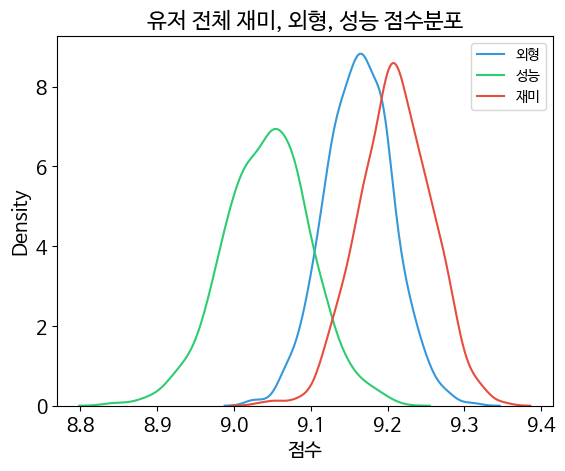

In [50]:
sns.kdeplot(tendency_score_per_user, x = '외형', label = '외형', color=color_dict['외형'])
sns.kdeplot(tendency_score_per_user, x = '성능', label = '성능', color=color_dict['성능'])
sns.kdeplot(tendency_score_per_user, x = '재미', label = '재미', color=color_dict['재미'])


plt.xlabel('점수', fontdict = {'size' : 14})
plt.ylabel('Density', fontdict = {'size' : 14})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('유저 전체 재미, 외형, 성능 점수분포', fontsize = 16)
plt.legend()
plt.show()
# tendency_score_per_user.hist(bins = 100)

### 픽률 top 10


In [28]:
# 픽률 top 10 액세서리

session_table = total_df.drop_duplicates(subset = ['플레이세션ID', '유저ID'])
session_num = len(session_table)
pick_rate_table = (session_table.groupby('액세서리')[['액세서리']].count()/session_num).rename(columns = {'액세서리' :'pick_rate'}).sort_values('pick_rate', ascending = False).reset_index()
pick_rate_table.head(10)


,액세서리,pick_rate
0,끈끈이발사기,0.002808
1,화끈화끈발사기,0.002808
2,아쿠아시미터,0.002709
3,심판의건틀릿,0.002709
4,파워드럼통,0.002660
5,여신의횃불,0.002660
6,화염가방,0.002660
7,트랜스볼,0.002611
8,이빌드래곤,0.002611
9,건쉽트랜스포머,0.002561


In [35]:
pick_top20_acc 

,액세서리,외형,성능,재미
0,끈끈이발사기,9.3,9.5,9.7
1,화끈화끈발사기,9.4,9.5,9.6
2,아쿠아시미터,9.7,9.7,9.5
3,심판의건틀릿,9.6,9.7,9.8
4,파워드럼통,9.2,9.3,9.6
5,여신의횃불,9.7,9.6,9.6
6,화염가방,9.6,9.5,9.8
7,트랜스볼,9.2,9.7,9.8
8,이빌드래곤,9.8,9.7,9.7
9,건쉽트랜스포머,9.6,9.5,9.6


/tmp/ipykernel_1097/2886476634.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pick20_plot_df,


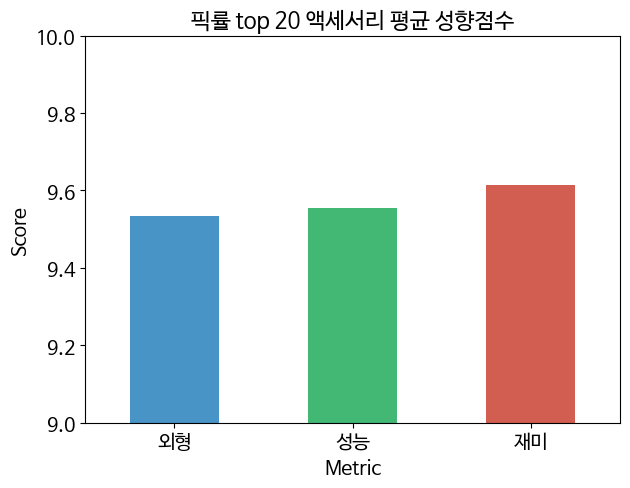

In [44]:
# 픽률 top 20 액세서리

pick_top20_acc = pd.merge(pick_rate_table.head(20), df_score, how = 'left', on = '액세서리')[['액세서리', '외형', '성능', '재미']]
pick20_plot_df = pick_top20_acc[['외형', '성능', '재미']].mean().reset_index().rename(columns = {"index" : "metric", 0 : "score"})

palette = [color_dict[m] for m in pick20_plot_df['metric']]
sns.barplot(data=pick20_plot_df,
            x='metric', y = 'score', palette=palette, width=0.5)


plt.xlabel('Metric', fontdict = {'size' : 14})
plt.ylabel('Score', fontdict = {'size' : 14})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.ylim(9, 10)    
plt.tight_layout()
plt.title('픽률 top 20 액세서리 평균 성향점수', fontsize = 16)
plt.show()

In [30]:
acc_count_per_class = session_table.groupby(['계급', '액세서리']).count()[['유저ID']].reset_index().rename(columns = {'유저ID' : 'count'})
total_by_class = acc_count_per_class.groupby('계급')[['count']].sum().reset_index().rename(columns = {'count' : 'total_cnt'})

acc_rates = acc_count_per_class.merge(total_by_class, how = 'left', on = '계급')
acc_rates['pick_rate_per_class'] = acc_rates['count']/acc_rates['total_cnt']
acc_rates

,계급,액세서리,count,total_cnt,pick_rate_per_class
0,금곰발,EPC전기충격봉,1,667,0.001499
1,금곰발,OMS-1,1,667,0.001499
2,금곰발,ROK암즈,1,667,0.001499
3,금곰발,RPS챔피언,3,667,0.004498
4,금곰발,가고일캐논,1,667,0.001499
...,...,...,...,...,...
8996,은황룡,플루토체인,1,80,0.012500
8997,은황룡,피닉스기어,1,80,0.012500
8998,은황룡,하피의날개,1,80,0.012500
8999,은황룡,환영의목걸이,1,80,0.012500


In [31]:
# 계급별 픽률이 제일 높은 액세서리 top 10의 점수를 통해 계급별 선호 성향을 파악악
acc_tmp = acc_rates.groupby('계급').apply(lambda x: x.nlargest(10, 'pick_rate_per_class')).drop('계급', axis =1).reset_index()

df_level_score = acc_tmp.merge(df_score, on = '액세서리', how = 'left').groupby('계급')[['외형', '성능', '재미']].mean()

/tmp/ipykernel_1097/2087773586.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  acc_tmp = acc_rates.groupby('계급').apply(lambda x: x.nlargest(10, 'pick_rate_per_class')).drop('계급', axis =1).reset_index()


In [32]:
df_level_score['class_level'] = df_level_score.reset_index()['계급'].map(class_level).values
df_level_score


,외형,성능,재미,class_level
계급,,,,
금곰발,9.31,9.15,9.36,18
금백호,9.36,9.27,9.38,6
금주작,9.20,9.19,9.56,9
금청룡,9.32,9.40,9.49,3
금코발,9.37,9.41,9.48,15
금현무,9.45,9.21,9.46,12
금황룡,8.99,9.07,9.30,0
동곰발,9.19,9.23,9.36,20
동백호,9.41,9.24,9.53,8


### 계급별 점수 성향

/tmp/ipykernel_1097/674855982.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='최고성향', data=df_level_score, palette='Set2', width = 0.3)


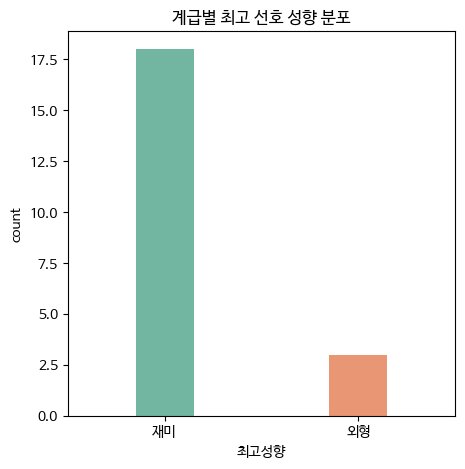

In [33]:
df_level_score['최고성향'] = df_level_score[['외형', '성능', '재미']].idxmax(axis=1)

plt.figure(figsize=(5, 5))
sns.countplot(x='최고성향', data=df_level_score, palette='Set2', width = 0.3)
plt.title("계급별 최고 선호 성향 분포")
plt.show()

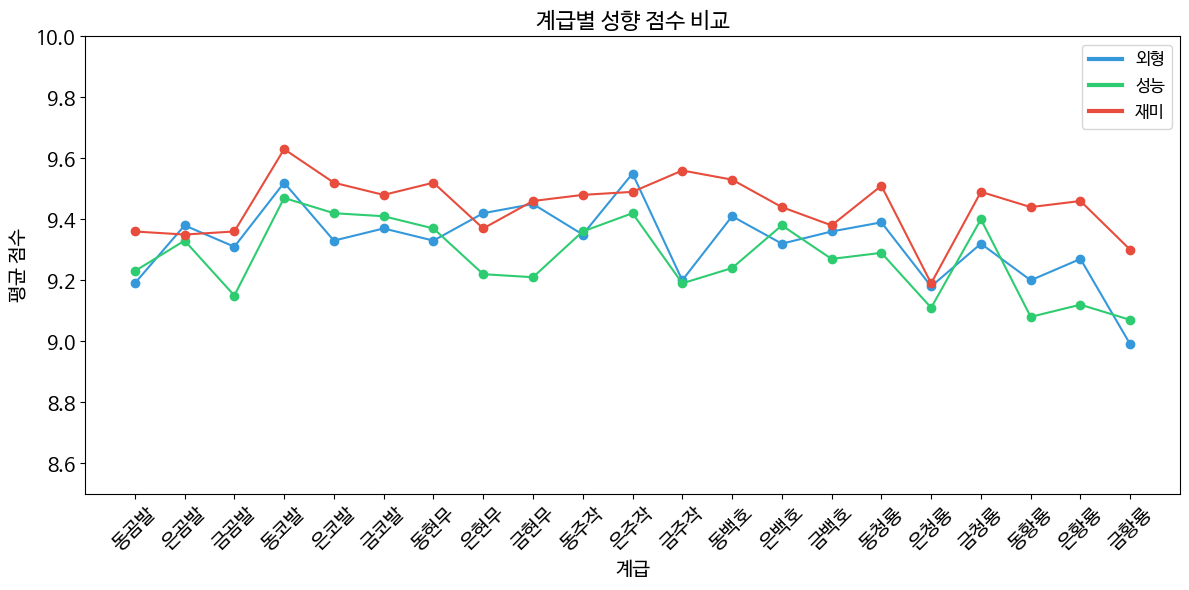

In [51]:
sorted_level_score = df_level_score.sort_values('class_level', ascending = False)
sorted_level_score.index = sorted_level_score.index.astype(str)

ax = sorted_level_score[['외형', '성능', '재미']].plot(kind='line', figsize=(12, 6), marker='o')

lines = ax.get_lines()
for line, col_name in zip(lines, ['외형', '성능', '재미']):
    line.set_color(color_dict[col_name])



plt.ylim(8.5, 10)

plt.title("계급별 성향 점수 비교", fontsize = 16)
plt.ylabel("평균 점수", fontsize = 14)
plt.xlabel('계급', fontsize = 14)
plt.xticks(ticks=range(len(sorted_level_score)), labels=sorted_level_score.index, rotation=45, fontsize = 14)
plt.yticks(fontsize = 14)
# legend를 직접 다시 세팅
legend_labels = ['외형', '성능', '재미']
legend_colors = [color_dict[label] for label in legend_labels]
custom_lines = [plt.Line2D([0], [0], color=color, lw=3) for color in legend_colors]
plt.legend(custom_lines, legend_labels, fontsize=12)

plt.tight_layout()
plt.show()

### 주요 맵 별 픽률 및 점수성향

In [52]:
# 주요 맵별 픽률, 전체적으로 해당 맵에서 어떤 액세서리르 사용하냐 
main_maps = top_maps + pop_maps + mid_maps

acc_count_per_map = session_table.groupby(['맵', '액세서리']).count()[['유저ID']].reset_index().rename(columns = {'유저ID' : 'count'})
total_by_map = acc_count_per_map.groupby('맵')[['count']].sum().reset_index().rename(columns = {'count' : 'total_cnt'})
total_by_main_map = acc_count_per_map.merge(total_by_map[total_by_map['맵'].isin(main_maps)], on = '맵', how = 'left')[acc_count_per_map['맵'].isin(main_maps)].reset_index(drop = True).astype({'total_cnt' : int})
total_by_main_map['pick_rate'] = total_by_main_map['count']/total_by_main_map['total_cnt']

total_by_main_map

,맵,액세서리,count,total_cnt,pick_rate
0,격투 경기장,EPC전기충격봉,3,2276,0.001318
1,격투 경기장,NBN26그레네이드벨트,1,2276,0.000439
2,격투 경기장,OMS-1,6,2276,0.002636
3,격투 경기장,ROK암즈,4,2276,0.001757
4,격투 경기장,RPS챔피언,6,2276,0.002636
...,...,...,...,...,...
4952,타이타닉,흑기사의갑옷,7,2255,0.003104
4953,타이타닉,히어로벨트,5,2255,0.002217
4954,타이타닉,히어로브로우스렛,6,2255,0.002661
4955,타이타닉,히트부스터,1,2255,0.000443


In [53]:
# acc_count_user = session_table.groupby(['유저ID', '맵', '액세서리']).size().reset_index(name='count')

# total_by_user_map = session_table.groupby(['유저ID', '맵']).size().reset_index(name='total_cnt')

# acc_count_user = acc_count_user.merge(total_by_user_map, on=['유저ID', '맵'])
# acc_count_user['pick_rate'] = acc_count_user['count'] / acc_count_user['total_cnt']

# acc_count_user = acc_count_user[acc_count_user['맵'].isin(main_maps)]

# final_pickrate = acc_count_user.groupby(['맵', '액세서리'])['pick_rate'].mean().reset_index().round(2)
# final_pickrate

In [54]:
total_by_main_map_top10 = total_by_main_map.groupby('맵').apply(lambda x: x.nlargest(10, 'pick_rate')).reset_index(drop = True)
total_by_main_map_top10  = total_by_main_map_top10.merge(df_score, on = '액세서리', how = 'left')[['맵', '액세서리', 'pick_rate', '외형', '성능', '재미']].reset_index()

/tmp/ipykernel_1097/4256508636.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  total_by_main_map_top10 = total_by_main_map.groupby('맵').apply(lambda x: x.nlargest(10, 'pick_rate')).reset_index(drop = True)


In [55]:
map_res = total_by_main_map_top10.groupby('맵')[['외형', '성능','재미']].mean()

map_res['gap'] = map_res['성능'] - map_res['재미']
map_res = map_res.reset_index()
map_res

,맵,외형,성능,재미,gap
0,격투 경기장,9.41,9.33,9.34,-0.01
1,골렘의 전당,9.22,9.26,9.41,-0.15
2,망자의 미궁,9.05,9.01,9.18,-0.17
3,메카신 대사원,9.17,9.17,9.44,-0.27
4,비밀의 방,9.38,9.44,9.49,-0.05
5,시티,9.44,9.49,9.49,0.00
6,원형 경기장,9.50,9.53,9.50,0.03
7,지하 감옥,9.35,9.25,9.44,-0.19
8,천년정글,9.30,9.19,9.38,-0.19
9,타이타닉,9.60,9.53,9.54,-0.01


### 유저별 선택맵 top5인 인기맵

In [56]:
user_map_cnt = session_table.groupby(['유저ID', '맵'])[['맵']].count().rename(columns = {'맵' : 'count'}).reset_index()
user_map_cnt_top5 = user_map_cnt.groupby(['유저ID']).apply(lambda x: x.nlargest(5, 'count')).reset_index(drop = True)

user_map_cnt_top5['rank'] = user_map_cnt_top5.groupby('유저ID')['count'].rank(method = 'dense', ascending = False)

map_rank_summary = user_map_cnt_top5.groupby('맵')['rank'].mean().reset_index().sort_values('rank').round(2)

map_rank_summary.head(10)

# user_map_pick['MapPickRate'] = 


/tmp/ipykernel_1097/3679468057.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_map_cnt_top5 = user_map_cnt.groupby(['유저ID']).apply(lambda x: x.nlargest(5, 'count')).reset_index(drop = True)


,맵,rank
52,원형 경기장,1.73
54,지하 감옥,1.75
60,타이타닉,2.39
40,시티,2.43
4,고산대불,2.50
47,오다이바,2.50
31,비밀의 방,2.57
2,격투 경기장,2.71
42,아바타 신전,3.00
37,산타의 집,3.00


In [57]:
gap_rank = map_res.merge(map_rank_summary, on = '맵', how = 'left')

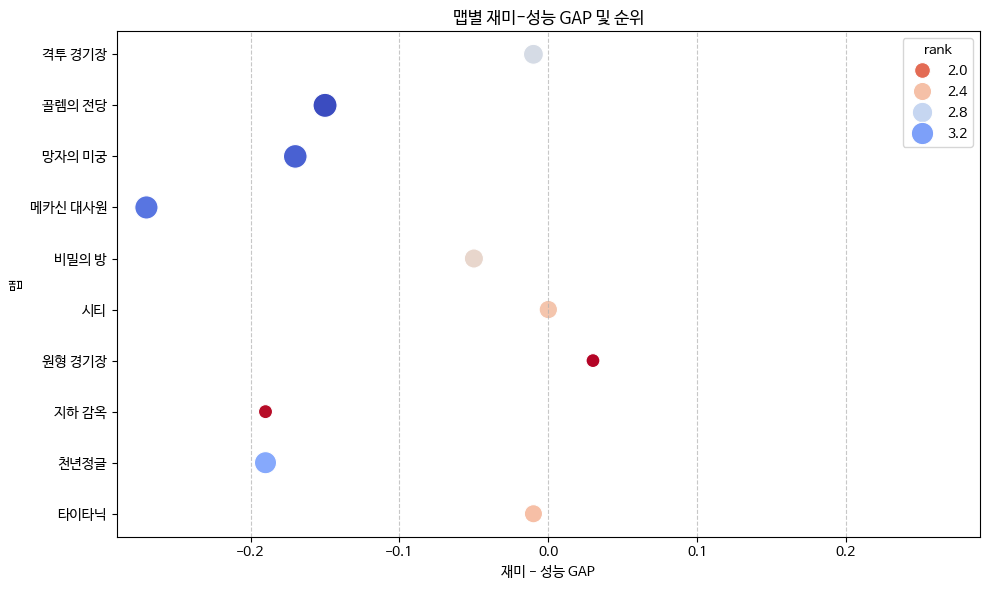

In [58]:
# 1. 그림 사이즈 설정
plt.figure(figsize=(10, 6))

# 2. scatter plot
sns.scatterplot(
    data= gap_rank,    # 네가 주신 테이블 이름
    x='gap',             # 재미-성능 차이
    y='맵',              # 맵 이름
    size='rank',         # 점 크기: rank
    hue='rank',          # 점 색깔: rank
    palette='coolwarm_r', # 색은 높은 rank(=안좋은 순위)일수록 차갑게
    sizes=(100, 300),    # 점 크기 범위 조정
    legend='brief'
)

# 3. 중심선 추가
gap_max = abs(gap_rank['gap'].max())
gap_min = abs(gap_rank['gap'].min())
gap_limit = max(gap_max, gap_min)
plt.xlim(-gap_limit-0.02, gap_limit+0.02)

plt.title('맵별 재미-성능 GAP 및 순위')
plt.xlabel('재미 - 성능 GAP')
plt.ylabel('맵')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

In [59]:
gap_rank.groupby('맵').mean()

,외형,성능,재미,gap,rank
맵,,,,,
격투 경기장,9.41,9.33,9.34,-0.01,2.71
골렘의 전당,9.22,9.26,9.41,-0.15,3.58
망자의 미궁,9.05,9.01,9.18,-0.17,3.49
메카신 대사원,9.17,9.17,9.44,-0.27,3.40
비밀의 방,9.38,9.44,9.49,-0.05,2.57
시티,9.44,9.49,9.49,0.00,2.43
원형 경기장,9.50,9.53,9.50,0.03,1.73
지하 감옥,9.35,9.25,9.44,-0.19,1.75
천년정글,9.30,9.19,9.38,-0.19,3.15


In [78]:
color_dict

{'재미': '#E74C3C', '외형': '#3498DB', '성능': '#2ECC71'}

In [81]:
df_sorted

,맵,외형,성능,재미,gap,rank,type
0,메카신 대사원,9.17,9.17,9.44,-0.27,3.40,재미
1,지하 감옥,9.35,9.25,9.44,-0.19,1.75,재미
2,천년정글,9.30,9.19,9.38,-0.19,3.15,재미
3,망자의 미궁,9.05,9.01,9.18,-0.17,3.49,재미
4,골렘의 전당,9.22,9.26,9.41,-0.15,3.58,재미
5,비밀의 방,9.38,9.44,9.49,-0.05,2.57,재미
6,타이타닉,9.60,9.53,9.54,-0.01,2.39,재미
7,격투 경기장,9.41,9.33,9.34,-0.01,2.71,재미
8,시티,9.44,9.49,9.49,0.00,2.43,재미
9,원형 경기장,9.50,9.53,9.50,0.03,1.73,성능


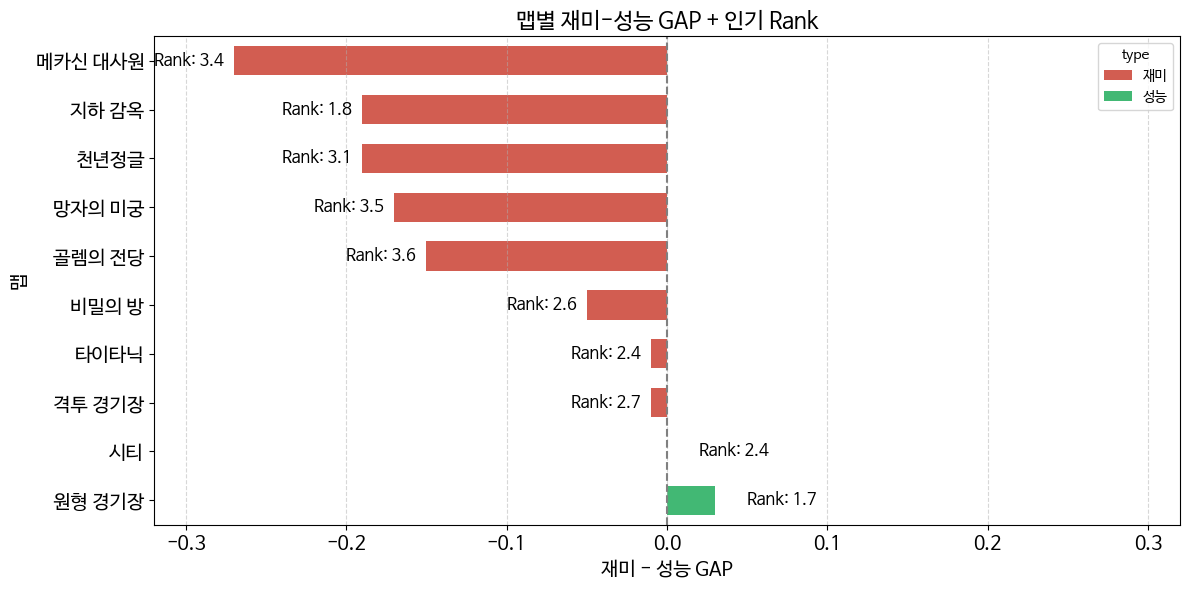

In [86]:
df_sorted = gap_rank.sort_values('gap').reset_index(drop=True)  # gap 순으로 정렬
df_sorted['type'] = df_sorted['gap'].apply(lambda x: '성능' if x >= 0 else '재미')
type_color_dict = {
    '재미': color_dict['재미'], 
    '성능': color_dict['성능']  
}
plt.figure(figsize=(12, 6))

# 막대그래프
sns.barplot(
    data=df_sorted,
    y='맵',
    x='gap',
    palette=type_color_dict,
    hue = 'type',
    width=0.6
)

# 중심선
plt.axvline(0, color='gray', linestyle='--')

gap_limit = max(abs(df_sorted['gap'].max()), abs(df_sorted['gap'].min()))
plt.xlim(-gap_limit - 0.05, gap_limit + 0.05)

# rank 숫자 표시 (막대 끝에)
for index, row in df_sorted.iterrows():
    plt.text(
        row['gap'] + (0.02 if row['gap'] >= 0 else -0.05),  # 막대 옆 위치
        index,
        f"Rank: {row['rank']:.1f}",
        color='black',
        va='center',
        fontsize=12
    )

plt.title('맵별 재미-성능 GAP + 인기 Rank', fontsize=16)
plt.xlabel('재미 - 성능 GAP', fontsize=14)
plt.ylabel('맵', fontsize=14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()
plt.show()

### 승패에 따른 점수 성향

In [61]:
# 승패에 따른 점수

session_table.groupby('승패여부')[['재미', '성능', '외형']].mean()

,재미,성능,외형
승패여부,,,
승,9.225648,9.057548,9.171914
패,9.191495,9.019670,9.145349


In [62]:
session_table.groupby(['계급','승패여부'])[['재미', '성능', '외형']].mean()

재미        성능        외형
계급  승패여부                              
금곰발 승     9.179921  9.018898  9.162205
    패     9.183293  9.021065  9.142131
금백호 승     9.218839  9.051380  9.173073
    패     9.154196  8.997582  9.116358
금주작 승     9.226141  9.047718  9.171162
    패     9.146522  8.967826  9.074130
금청룡 승     9.242105  9.053759  9.148496
    패     9.222794  9.033824  9.131618
금코발 승     9.261538  9.111189  9.197552
    패     9.249664  9.061298  9.176957
금현무 승     9.224597  9.051537  9.182723
    패     9.172159  8.996449  9.123864
금황룡 승     9.172131  9.026230  9.104918
    패     9.152174  9.000000  9.178261
동곰발 승     9.231126  9.099669  9.193709
    패     9.189882  9.042664  9.144351
동백호 승     9.209192  9.041226  9.160724
    패     9.155310  8.951659  9.123673
동주작 승     9.213255  9.028719  9.155965
    패     9.228299  9.049388  9.178231
동청룡 승     9.257874  9.072441  9.169291
    패     9.216754  9.027749  9.158115
동코발 승     9.250617  9.093333  9.203704
    패     9.188126  9.032904  9.141059
동현무 승     9.252031  9.091406  9.203281
    패     9.201826  9.049543  9.145548
동황룡 승     9.366667  9.113889  9.252778
    패     9.121053  8.863158  9.100000
은곰발 승     9.260140  9.098951  9.216084
    패     9.201984  9.023016  9.168056
은백호 승     9.235502  9.064211  9.172249
    패     9.194554  9.017698  9.139851
은주작 승     9.224106  9.061854  9.160530
    패     9.203419  9.025499  9.157977
은청룡 승     9.230769  9.107692  9.241758
    패     9.226214  9.032039  9.155340
은코발 승     9.223837  9.047093  9.152907
    패     9.207544  9.048743  9.169826
은현무 승     9.184730  9.013784  9.129324
    패     9.192991  9.027220  9.170911
은황룡 승     9.280357  9.057143  9.158929
    패     9.262500  9.025000  9.245833

### 승률에 따른 액세서리 픽 및 점수성향

In [63]:
win_counts = df_log.groupby(['액세서리', '승패여부']).size().unstack(fill_value=0)

win_counts['승률'] = win_counts['승'] / (win_counts['승'] + win_counts['패'])

win_counts

승패여부,승,패,승률
액세서리,,,
EPC전기충격봉,228,234,0.493506
NBN26그레네이드벨트,142,182,0.438272
OMS-1,331,326,0.503805
ROK암즈,176,181,0.492997
RPS챔피언,247,254,0.493014
...,...,...,...
흑기사의갑옷,269,274,0.495396
히어로벨트,230,262,0.467480
히어로브로우스렛,258,279,0.480447


In [64]:
acc_win_rate = df_score.merge(win_counts.sort_values('승률', ascending = False).reset_index(), on = '액세서리', how = 'left')[['액세서리','승률', '외형', '성능', '재미']]
acc_win_rate.sort_values('승률', ascending = False).tail(20)

,액세서리,승률,외형,성능,재미
660,검도호구,0.412844,8.3,8.2,8.7
648,마스코트세트,0.412698,7.9,6.0,6.6
34,외계인변신벨트,0.410667,8.4,7.7,8.4
533,야수의목걸이,0.404984,7.6,7.4,8.4
5,듀얼펜서,0.402516,7.6,6.1,5.9
51,페이탈스트라이프,0.399306,8.9,7.3,7.5
21,오미너스스타,0.399061,7.8,6.5,6.8
14,엽기햄스터슈트,0.398374,8.7,6.8,7.9
80,패러사이트웜,0.395833,7.3,6.8,7.7
45,코즈믹피스-루나,0.391437,9.0,7.2,7.5


In [65]:
acc_win_rate.sort_values('승률', ascending = False).query('`승률` > 0.45 & `승률` < 0.5')

,액세서리,승률,외형,성능,재미
249,신선의수염,0.499320,9.8,9.8,9.5
362,요정의팔찌,0.499225,9.6,9.6,9.6
631,지뢰포트,0.499154,9.2,9.0,9.0
530,암바주카,0.499014,9.0,8.8,9.1
430,엽기팬더슈트,0.498990,9.5,8.9,9.3
...,...,...,...,...,...
399,엽기양슈트,0.450617,9.6,9.6,9.7
272,스파르타스피어,0.450521,8.4,8.0,8.5
134,케이지해머,0.450450,8.3,8.4,8.9
397,야옹야옹세트,0.450249,8.3,7.9,8.2


In [66]:
# 픽률과 재미간 상관성

pick_rate_table.merge(df_score, on = '액세서리', how = 'left')[['pick_rate', '재미', '외형', '성능']].corr()

,pick_rate,재미,외형,성능
pick_rate,1.000000,0.699739,0.671766,0.729626
재미,0.699739,1.000000,0.751407,0.873982
외형,0.671766,0.751407,1.000000,0.764051
성능,0.729626,0.873982,0.764051,1.000000


In [67]:
acc_win_rate[['승률', '외형', '성능', '재미']].corr()

,승률,외형,성능,재미
승률,1.000000,0.523425,0.698568,0.634530
외형,0.523425,1.000000,0.764051,0.751407
성능,0.698568,0.764051,1.000000,0.873982
재미,0.634530,0.751407,0.873982,1.000000


In [68]:
pick_rate_table

,액세서리,pick_rate
0,끈끈이발사기,0.002808
1,화끈화끈발사기,0.002808
2,아쿠아시미터,0.002709
3,심판의건틀릿,0.002709
4,파워드럼통,0.002660
...,...,...
656,이모션마스크,0.000345
657,정의의천칭,0.000296
658,인라인스케이트,0.000246
659,백설공주,0.000246


In [69]:
pick_win_table = pick_rate_table.merge(acc_win_rate, on = '액세서리', how = 'left').sort_values(['승률', 'pick_rate'], ascending = [False, True])

In [70]:
pick_win_table

,액세서리,pick_rate,승률,외형,성능,재미
193,시저스엣지,0.001773,0.553846,9.5,9.4,9.4
399,세일러지팡이,0.001379,0.551282,9.0,8.8,9.5
349,고릴라인형,0.001478,0.550427,9.6,9.2,9.3
89,숄더캐논,0.002020,0.548851,9.4,9.9,9.6
8,이빌드래곤,0.002611,0.547786,9.8,9.7,9.7
...,...,...,...,...,...,...
658,인라인스케이트,0.000246,0.371429,6.4,6.4,6.4
656,이모션마스크,0.000345,0.366667,5.0,4.9,5.6
645,할파스의마검,0.000542,0.344086,7.9,6.6,6.9
651,패러사이트스토커,0.000443,0.325000,7.0,5.8,6.9


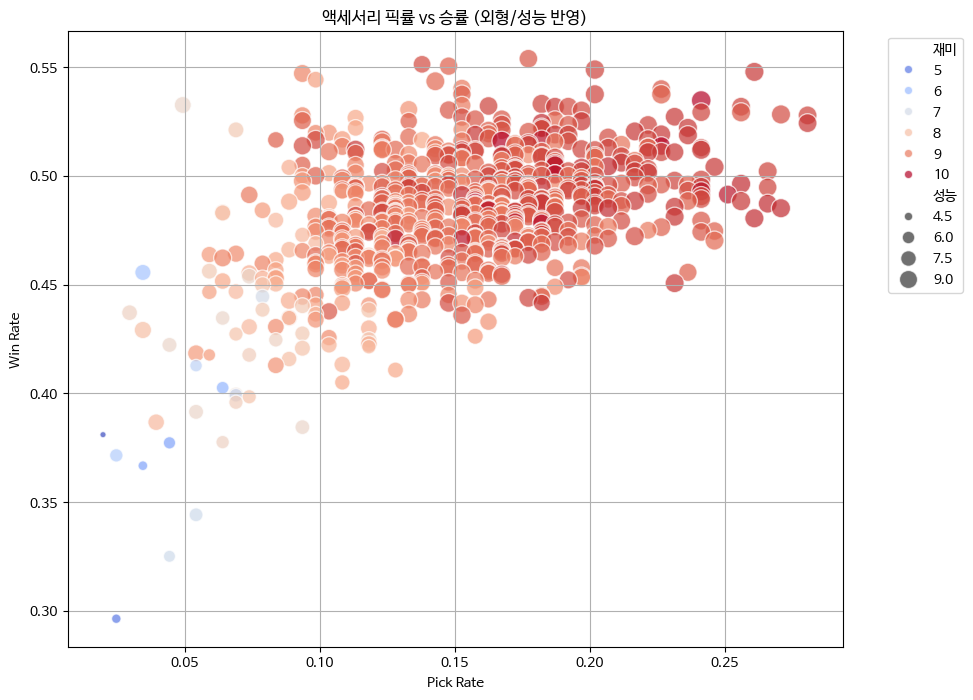

In [71]:
plt.figure(figsize=(10,8))
pick_win_table['pick_rate(%)'] = pick_win_table['pick_rate'] * 100

sns.scatterplot(
    data=pick_win_table,
    x='pick_rate(%)', 
    y='승률',
    size='성능',       # 성능 점수가 높을수록 점이 커지게
    hue='재미',        # 외형 점수에 따라 색이 달라지게
    palette='coolwarm', # 색상 팔레트 (예시)
    sizes=(20, 200),   # 점 크기 범위
    alpha=0.7          # 투명도
)

plt.title('액세서리 픽률 vs 승률 (외형/성능 반영)')
plt.xlabel('Pick Rate')
plt.ylabel('Win Rate')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)  # 범례를 옆으로
plt.show()

/tmp/ipykernel_1097/3789950733.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


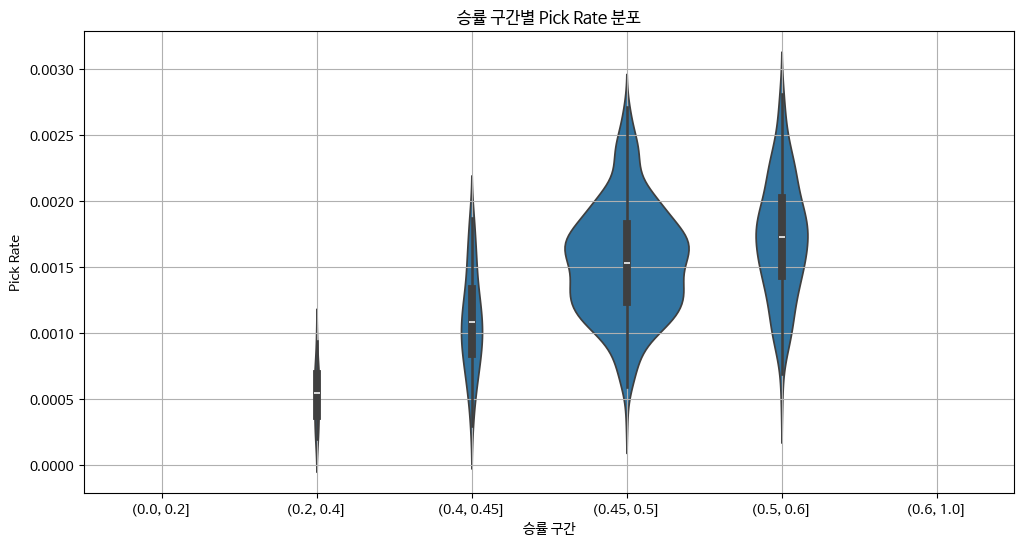

In [72]:
# 1. 먼저 승률 구간 만들기
pick_win_table['win_rate_bin'] = pd.cut(pick_win_table['승률'], bins=[0, 0.2, 0.4, 0.45, 0.5, 0.6, 1])

# 2. 승률 구간별 pick_rate 분포 violinplot
plt.figure(figsize=(12,6))
sns.violinplot(
    data=pick_win_table,
    x='win_rate_bin',
    y='pick_rate',
    scale='count',
    inner='box',
)
plt.title('승률 구간별 Pick Rate 분포')
plt.xlabel('승률 구간')
plt.ylabel('Pick Rate')
plt.grid(True)
plt.show()

/tmp/ipykernel_1097/1530150355.py:6: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


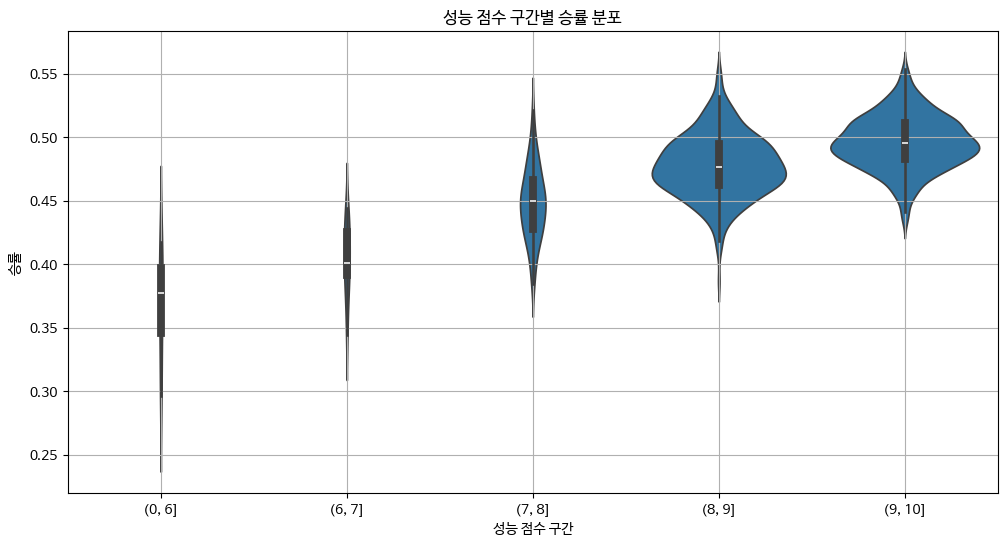

/tmp/ipykernel_1097/1530150355.py:24: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='count'` for the same effect.
  sns.violinplot(


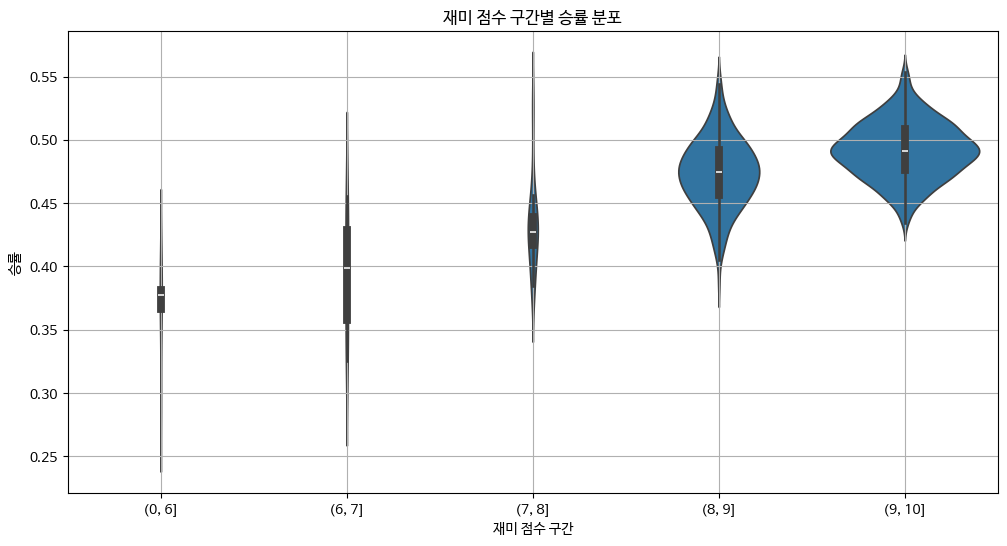

In [73]:
# 1. 성능 점수 구간 만들기
pick_win_table['performance_bin'] = pd.cut(pick_win_table['성능'], bins=[0, 6, 7, 8, 9, 10])

# 2. 성능 구간별 승률 분포 그리기
plt.figure(figsize=(12,6))
sns.violinplot(
    data=pick_win_table,
    x='performance_bin',
    y='승률',
    scale='count',
    inner='box',
)
plt.title('성능 점수 구간별 승률 분포')
plt.xlabel('성능 점수 구간')
plt.ylabel('승률')
plt.grid(True)
plt.show()

# 1. 재미 점수 구간 만들기
pick_win_table['fun_bin'] = pd.cut(pick_win_table['재미'], bins=[0, 6, 7, 8, 9, 10])

# 2. 재미 구간별 승률 분포 그리기
plt.figure(figsize=(12,6))
sns.violinplot(
    data=pick_win_table,
    x='fun_bin',
    y='승률',
    scale='count',    # 샘플 수에 비례해서 넓이 조절
    inner='box',      # 안에 boxplot도 같이 그리기
)
plt.title('재미 점수 구간별 승률 분포')
plt.xlabel('재미 점수 구간')
plt.ylabel('승률')
plt.grid(True)
plt.show()

In [87]:
from sklearn.linear_model import LinearRegression

# 독립변수: 재미, 외형, 성능
X = pick_win_table[['재미', '외형', '성능']]

# 종속변수: 픽률
y_pick = pick_win_table['pick_rate']

# 모델 만들고 학습
model_pick = LinearRegression()
model_pick.fit(X, y_pick)

print("픽률에 대한 계수:", model_pick.coef_)
print("픽률에 대한 절편:", model_pick.intercept_)

픽률에 대한 계수: [0.00013208 0.00019749 0.00025385]
픽률에 대한 절편: -0.0037202226760441525


In [88]:
# 종속변수: 승률
y_win = pick_win_table['승률']

model_win = LinearRegression()
model_win.fit(X, y_win)

print("승률에 대한 계수:", model_win.coef_)
print("승률에 대한 절편:", model_win.intercept_)

승률에 대한 계수: [ 0.00584725 -0.0026722   0.0272063 ]
승률에 대한 절편: 0.21116463302169225


/tmp/ipykernel_1097/3305387925.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = pick_coef, y='metric', x='score', palette=palette, width = 0.5)


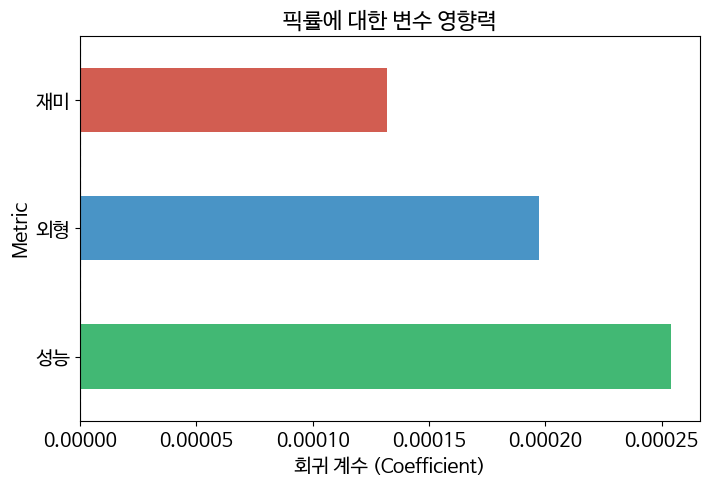

In [95]:
feature_names = ['재미', '외형', '성능']
coef_pick = model_pick.coef_.tolist()

dict_ = {feature_names[0] : [coef_pick[0]],
         feature_names[1] : [coef_pick[1]],
         feature_names[2] : [coef_pick[2]]}

pick_coef = pd.DataFrame(dict_).T.rename(columns = {0 : 'score'}).reset_index(names = 'metric')
palette = [color_dict[m] for m in pick_coef['metric']]
# 막대그래프
plt.figure(figsize=(8,5))
sns.barplot(data = pick_coef, y='metric', x='score', palette=palette, width = 0.5)
plt.axvline(0, color='gray', linestyle='--')
# plt.barh(feature_names, coef_pick)
plt.title('픽률에 대한 변수 영향력', fontsize = 16)
plt.xlabel('회귀 계수 (Coefficient)', fontsize = 14)
plt.ylabel('Metric', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.grid(True)
plt.show()

/tmp/ipykernel_1097/503618477.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = win_coef, y='metric', x='score', palette=palette, width = 0.5)


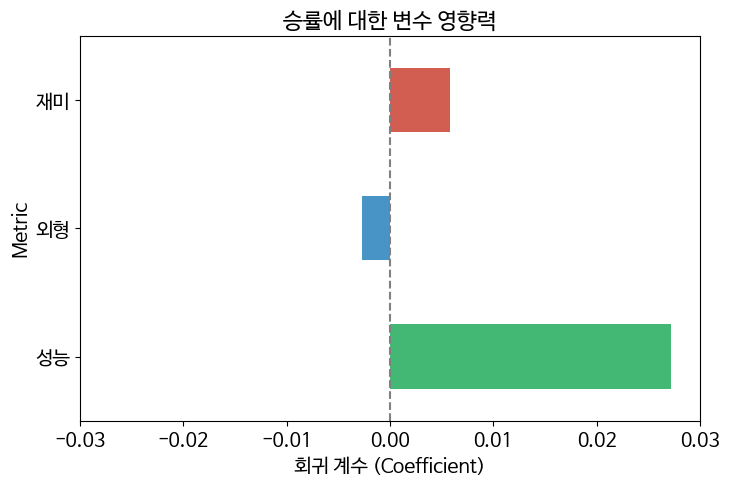

In [97]:
feature_names = ['재미', '외형', '성능']
coef_win = model_win.coef_.tolist()

dict_ = {feature_names[0] : [coef_win[0]],
         feature_names[1] : [coef_win[1]],
         feature_names[2] : [coef_win[2]]}

win_coef = pd.DataFrame(dict_).T.rename(columns = {0 : 'score'}).reset_index(names = 'metric')
palette = [color_dict[m] for m in win_coef['metric']]
# 막대그래프
plt.figure(figsize=(8,5))
sns.barplot(data = win_coef, y='metric', x='score', palette=palette, width = 0.5)
plt.axvline(0, color='gray', linestyle='--')
plt.xlim((-0.03, 0.03))
plt.title('승률에 대한 변수 영향력', fontsize = 16)
plt.xlabel('회귀 계수 (Coefficient)', fontsize = 14)
plt.ylabel('Metric', fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.grid(True)
plt.show()

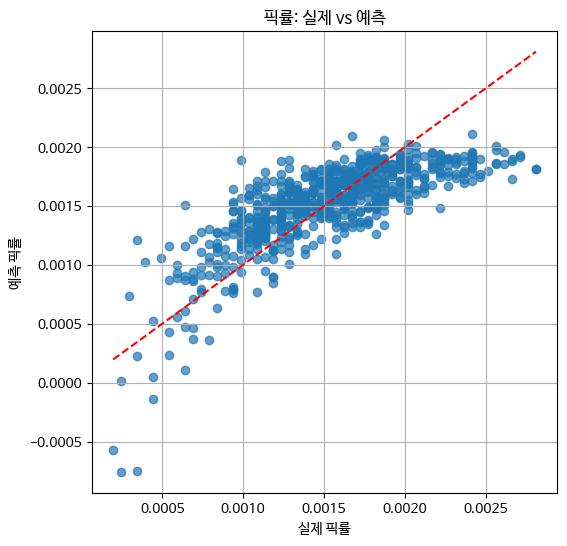

In [ ]:
y_pick_pred = model_pick.predict(X)

# 실제 vs 예측 비교
plt.figure(figsize=(6,6))
plt.scatter(y_pick, y_pick_pred, alpha=0.7)
plt.plot([y_pick.min(), y_pick.max()], [y_pick.min(), y_pick.max()], 'r--')  # y=x 선
plt.title('픽률: 실제 vs 예측')
plt.xlabel('실제 픽률')
plt.ylabel('예측 픽률')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

x = y_pick.values.reshape(-1, 1)      # 실제값
y = y_pick_pred.reshape(-1, 1)

model_linear = LinearRegression()
model_linear.fit(x, y)
y_linear_pred = model_linear.predict(x)
r2_linear = r2_score(y, y_linear_pred)

# 다항 특성 생성 (2차)
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(x)

# 2차 회귀 학습
model_poly = LinearRegression()
model_poly.fit(X_poly, y)
y_poly_pred = model_poly.predict(X_poly)
r2_poly = r2_score(y, y_poly_pred)



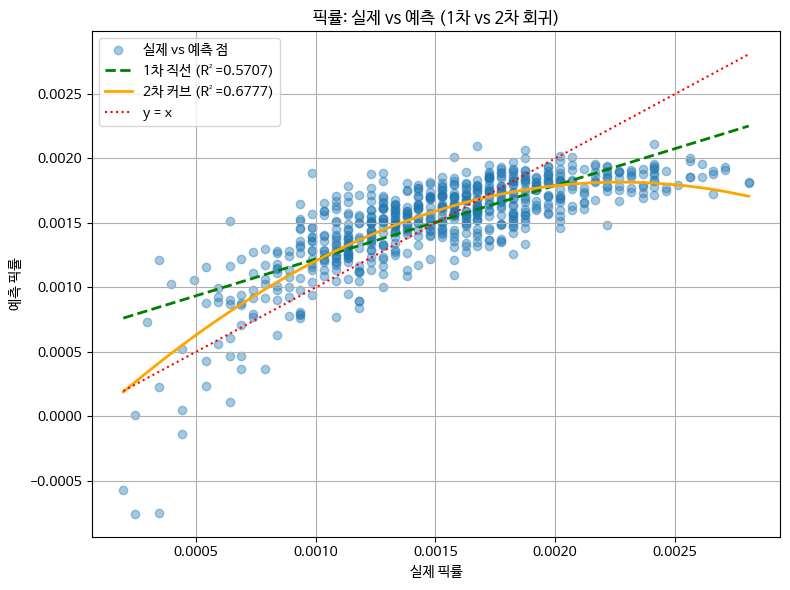

In [ ]:
# 1차원으로 변환
x_flat = x.flatten()
y_flat = y.flatten()
y_linear_flat = y_linear_pred.flatten()
y_poly_flat = y_poly_pred.flatten()

# 정렬 인덱스
sort_idx = np.argsort(x_flat)

plt.figure(figsize=(8,6))
plt.scatter(x_flat, y_flat, alpha=0.4, label='실제 vs 예측 점')

# 1차 회귀 직선
plt.plot(x_flat[sort_idx], y_linear_flat[sort_idx], 'g--', label=f'1차 직선 (R²={r2_linear:.4f})', linewidth=2)

# 2차 커브 회귀
plt.plot(x_flat[sort_idx], y_poly_flat[sort_idx], 'orange', label=f'2차 커브 (R²={r2_poly:.4f})', linewidth=2)

# 기준선 (y = x)
plt.plot([x_flat.min(), x_flat.max()], [x_flat.min(), x_flat.max()], 'r:', label='y = x')

plt.title('픽률: 실제 vs 예측 (1차 vs 2차 회귀)')
plt.xlabel('실제 픽률')
plt.ylabel('예측 픽률')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# 계수와 절편
coefs = model_poly.coef_.flatten()   # [β₀(더미), β₁, β₂]
intercept = model_poly.intercept_[0] # β₀ (intercept)

# 실제 사용되는 계수만 보여줌 (x, x² 계수)
print(f"2차 회귀 계수:")
print(f"절편 (β₀): {intercept:.6f}")
print(f"선형항 계수 (β₁): {coefs[1]:.6f}")
print(f"2차항 계수 (β₂): {coefs[2]:.6f}")

2차 회귀 계수:
절편 (β₀): -0.000135
선형항 계수 (β₁): 1.718709
2차항 계수 (β₂): -378.509229
